In [18]:
import pandas as pd
from ast import literal_eval
import re
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
import matplotlib

In [2]:
def convert_to_float_list(x):
    cleaned_string = re.sub("\s+", ",", x[1:-1].strip())
    return [float(y) for y in cleaned_string.split(",")]

In [3]:
def read_results(results_file, dataset):
    results_df = pd.read_csv(results_file, sep='\t', names = ['method', 'training_size', 'align_error', 'source_error', 'target_error'
                                                                  , 'hits', 'mr', 'mrr'])
    results_df['hits'] = results_df['hits'].apply(lambda x: convert_to_float_list(x))
    results_df[['hits@1','hits@5','hits@10','hits@50','hits@100']] = pd.DataFrame(results_df.hits.tolist(), index= results_df.index)
    results_df['dataset'] = dataset
    results_df['combined_error'] = results_df['align_error'] + results_df['source_error'] + results_df['target_error']
    results_df['multiply_quality'] = (100-results_df['align_error'])*(100-results_df['source_error'])*(100-results_df['target_error'])/(100**3)
    
    return results_df

In [4]:
ids_results = read_results('IDS15K_results.txt', 'ids')
ids_results['error_comb'] = list(zip(ids_results.align_error, ids_results.source_error, ids_results.target_error))

In [5]:
dbp_results = read_results('DBP15K_results.txt', 'dbp')
dbp_results['error_comb'] = list(zip(dbp_results.align_error, dbp_results.source_error, dbp_results.target_error))

In [6]:
all_results_df = pd.concat([dbp_results,ids_results], ignore_index=True)

In [7]:
results_df_30 = all_results_df.loc[(all_results_df.training_size==30)*all_results_df.method.str.contains('random')]

In [8]:
grouped_df = results_df_30[['hits@1', 'hits@5', 'mrr', 'combined_error', 
                            'method', 'dataset']].groupby(['combined_error', 'method', 'dataset']).mean()
dataset_index = grouped_df.index.get_level_values(2)
method_index = grouped_df.index.get_level_values(1)

ids_30_df = grouped_df[dataset_index == 'ids']
dbp_30_df = grouped_df[(dataset_index == 'dbp')*(~method_index.str.contains('jape'))]

df = ids_30_df.copy()

# Assuming your DataFrame is named 'df' with MultiIndex
# First reset the index to make combined_error and method regular columns
df = df.reset_index()

# Clean up method names (optional)
df['method'] = df['method'].str.replace('_random', '')
df = df.round(decimals = 2)
# Create the scores tuple column
df['scores'] = df.apply(lambda x: (x['hits@1'], x['hits@5'], x['mrr']), axis=1)

# Pivot the table with method as rows and combined_error as columns
pivoted_df = df.pivot(index='method', columns='combined_error', values='scores')

# Reorder rows if needed and rename index
pivoted_df = pivoted_df.reindex(['bootea', 'gcnalign', 'jape'])
pivoted_df.index = ['BootEA', 'GCN-Align', 'JAPE']

# Sort columns numerically (they might become strings during pivot)
pivoted_df = pivoted_df.reindex(columns=sorted(pivoted_df.columns, key=lambda x: int(x)))

In [9]:
print(pivoted_df[[0, 60, 120]].to_latex())

\begin{tabular}{llll}
\toprule
combined\_error &                   0   &                   60  &                  120 \\
\midrule
BootEA    &  (71.19, 86.29, 0.78) &  (39.78, 58.41, 0.48) &   (9.6, 19.94, 0.15) \\
GCN-Align &  (62.77, 81.79, 0.71) &   (22.03, 38.97, 0.3) &  (7.43, 15.27, 0.11) \\
JAPE      &  (47.17, 69.73, 0.58) &   (9.25, 19.59, 0.15) &    (1.05, 3.0, 0.02) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_10346/814839602.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pivoted_df[[0, 60, 120]].to_latex())


In [10]:
df = dbp_30_df.copy()

# Assuming your DataFrame is named 'df' with MultiIndex
# First reset the index to make combined_error and method regular columns
df = df.reset_index()

# Clean up method names (optional)
df['method'] = df['method'].str.replace('_random', '')
df = df.round(decimals = 2)
# Create the scores tuple column
df['scores'] = df.apply(lambda x: (x['hits@1'], x['hits@5'], x['mrr']), axis=1)

# Pivot the table with method as rows and combined_error as columns
pivoted_df = df.pivot(index='method', columns='combined_error', values='scores')

# Reorder rows if needed and rename index
pivoted_df = pivoted_df.reindex(['bootea', 'gcnalign'])
pivoted_df.index = ['BootEA', 'GCN-Align']

# Sort columns numerically (they might become strings during pivot)
pivoted_df = pivoted_df.reindex(columns=sorted(pivoted_df.columns, key=lambda x: int(x)))

In [11]:
print(pivoted_df[[0, 60, 120]].to_latex())

\begin{tabular}{llll}
\toprule
combined\_error &                   0   &                   60  &                   120 \\
\midrule
BootEA    &  (54.43, 77.52, 0.65) &  (32.25, 57.52, 0.44) &  (11.27, 25.81, 0.19) \\
GCN-Align &  (28.88, 51.43, 0.39) &   (13.39, 27.01, 0.2) &   (5.47, 11.51, 0.09) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_10346/814839602.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pivoted_df[[0, 60, 120]].to_latex())


## Error Source

In [12]:
ids_30_df = results_df_30.loc[results_df_30.dataset == 'ids']

In [25]:
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

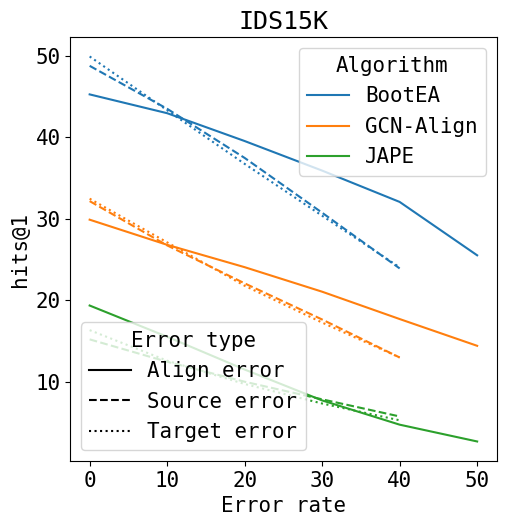

In [30]:
ax = ids_30_df[['hits@1', 'align_error', 'method']].groupby(['align_error', 'method']).mean(numeric_only=True).reset_index().pivot(index="align_error",
                columns="method")['hits@1'].plot(title = 'IDS15K',
                    linestyle = 'solid', xlabel = 'Error rate',
                   ylabel='hits@1')
ax.set_prop_cycle(None)
ax.plot(ids_30_df[['hits@1', 'source_error', 'method']].groupby(['source_error', 'method']).mean(numeric_only=True).reset_index().pivot(index="source_error",
                    columns="method")['hits@1'], linestyle='dashed')
ax.set_prop_cycle(None)
ax.plot(ids_30_df[['hits@1', 'target_error', 'method']].groupby(['target_error', 'method']).mean(numeric_only=True).reset_index().pivot(index="target_error",
                    columns="method")['hits@1'], linestyle='dotted')
#ax.legend(['GCN-Align', 'JAPE'], title='Alignment algorithm')

algorithm_lines = []
algorithm_lines.append(mlines.Line2D([],[], c="C0",label='BootEA'))
algorithm_lines.append(mlines.Line2D([],[], c="C1", label='GCN-Align'))
algorithm_lines.append(mlines.Line2D([],[], c="C2", label='JAPE'))

error_lines = []
error_lines.append(mlines.Line2D([],[], c="black", ls = 'solid', label='Align error'))
error_lines.append(mlines.Line2D([],[], c="black", ls = 'dashed', label='Source error'))
error_lines.append(mlines.Line2D([],[], c="black", ls = 'dotted', label='Target error'))

legend1 = plt.legend(handles=algorithm_lines, title='Algorithm', loc=1)
legend2 = ax.legend(handles=[error_lines[i] for i in [0,1,2]], title='Error type', loc=3)
ax.add_artist(legend1)

fig = ax.get_figure()
fig.set_size_inches(5.5, 5.5)
fig.savefig('error_source_perf_ids.pdf', dpi=100, bbox_inches='tight')

In [27]:
dbp_30_df = results_df_30.loc[(results_df_30.dataset == 'dbp')*(~results_df_30.method.str.contains('jape'))]

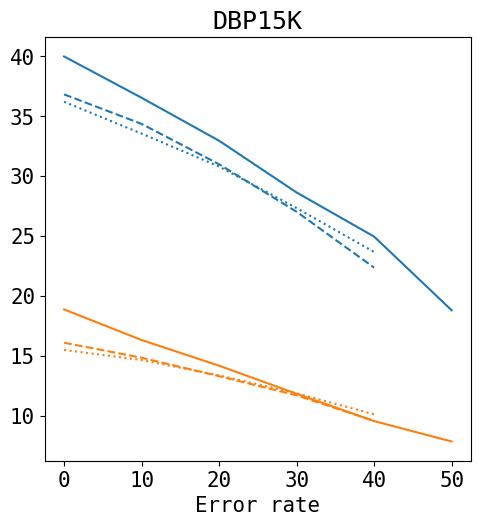

In [28]:
ax = dbp_30_df[['hits@1', 'align_error', 'method']].groupby(['align_error', 'method']).mean(numeric_only=True).reset_index().pivot(index="align_error",
                columns="method")['hits@1'].plot(title = 'DBP15K',
                    linestyle = 'solid', xlabel = 'Error rate',
                   ylabel=None)
ax.set_prop_cycle(None)
ax.plot(dbp_30_df[['hits@1', 'source_error', 'method']].groupby(['source_error', 'method']).mean(numeric_only=True).reset_index().pivot(index="source_error",
                    columns="method")['hits@1'], linestyle='dashed')
ax.set_prop_cycle(None)
ax.plot(dbp_30_df[['hits@1', 'target_error', 'method']].groupby(['target_error', 'method']).mean(numeric_only=True).reset_index().pivot(index="target_error",
                    columns="method")['hits@1'], linestyle='dotted')

ax.get_legend().remove()
#legend1 = plt.legend(handles=algorithm_lines, title='Algorithm', loc=1)
#legend2 = ax.legend(handles=[error_lines[i] for i in [0,1,2]], title='Error type', loc=3)
#ax.add_artist(legend1)

fig = ax.get_figure()
fig.set_size_inches(5.5, 5.5)
fig.savefig('error_source_perf_dbp.pdf', dpi=100, bbox_inches='tight')

## Error Combination

In [31]:
grouped_df = results_df_30[['hits@1', 'combined_error', 'method', 'dataset']].groupby(['combined_error', 'method', 'dataset'])
concat_df = pd.concat([grouped_df.mean(), grouped_df.max(), grouped_df.min()], axis=1)
keys = ['average', 'max', 'min']
concat_df.columns = keys
dataset_index = concat_df.index.get_level_values(2)
method_index = concat_df.index.get_level_values(1)

ids_30_df = concat_df[dataset_index == 'ids']
dbp_30_df = concat_df[(dataset_index == 'dbp')*(~method_index.str.contains('jape'))]

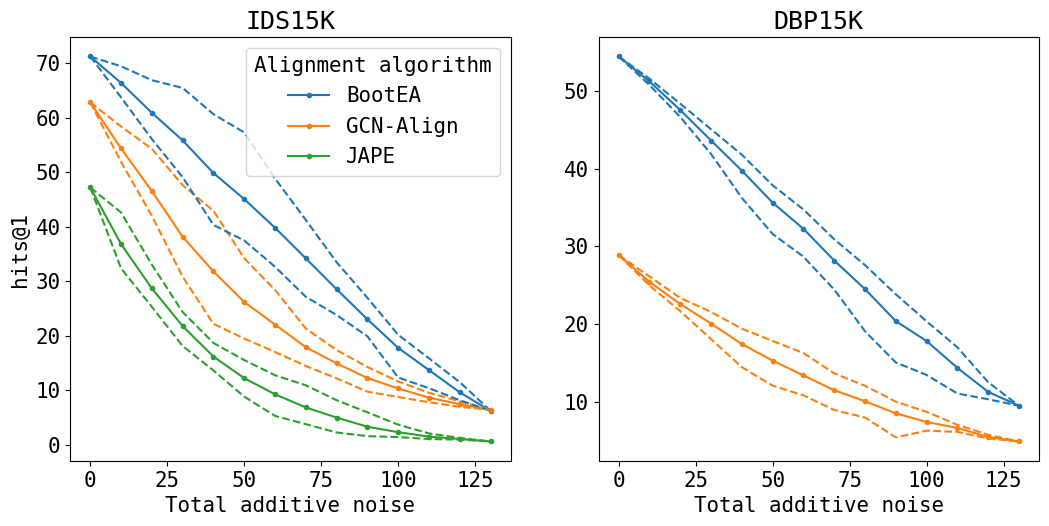

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2)#, constrained_layout=True)
fig.set_size_inches(12.5, 5.5)
#fig.suptitle('Algorithm Performance for Different Noise Levels', fontsize=15)

axes[0].plot(ids_30_df.reset_index().pivot(index="combined_error", columns="method")['average'], linestyle = 'solid', marker = '.')
axes[0].set_prop_cycle(None)
axes[0].plot(ids_30_df.reset_index().pivot(index="combined_error", columns="method")['max'], linestyle='dashed')
axes[0].set_prop_cycle(None)
axes[0].plot(ids_30_df.reset_index().pivot(index="combined_error", columns="method")['min'], linestyle='dashed')

axes[0].set_title('IDS15K')
axes[0].legend(['BootEA', 'GCN-Align', 'JAPE'], title='Alignment algorithm')
axes[0].set_xlabel("Total additive noise")
axes[0].set_ylabel("hits@1")

axes[1].plot(dbp_30_df.reset_index().pivot(index="combined_error", columns="method")['average'], linestyle = 'solid', marker = '.')
axes[1].set_prop_cycle(None)
axes[1].plot(dbp_30_df.reset_index().pivot(index="combined_error", columns="method")['max'], linestyle='dashed')
axes[1].set_prop_cycle(None)
axes[1].plot(dbp_30_df.reset_index().pivot(index="combined_error", columns="method")['min'], linestyle='dashed')

axes[1].set_title('DBP15K')
axes[1].set_xlabel("Total additive noise")

fig.savefig('total_perf_both.pdf', dpi=100, bbox_inches='tight')

In [34]:
ids_30_df = results_df_30.loc[results_df_30.dataset == 'ids']
dbp_30_df = results_df_30.loc[(results_df_30.dataset == 'dbp')*(~results_df_30.method.str.contains('jape'))]

In [35]:
idx = ids_30_df.groupby(['combined_error', 'method'])['hits@1'].transform(max) == ids_30_df['hits@1']
top_ids = ids_30_df[idx][['method','combined_error', 'error_comb']].sort_values('combined_error')
print(top_ids.pivot(index = 'method', columns = 'combined_error')['error_comb'][[30, 50, 70, 90]].to_latex())

\begin{tabular}{lllll}
\toprule
combined\_error &          30 &           50 &            70 &            90 \\
method          &             &              &               &               \\
\midrule
bootea\_random   &  (30, 0, 0) &   (50, 0, 0) &  (50, 10, 10) &  (40, 20, 30) \\
gcnalign\_random &  (30, 0, 0) &   (50, 0, 0) &  (50, 10, 10) &  (50, 20, 20) \\
jape\_random     &  (30, 0, 0) &  (0, 30, 20) &   (0, 40, 30) &  (10, 40, 40) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_10346/3038316213.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top_ids.pivot(index = 'method', columns = 'combined_error')['error_comb'][[30, 50, 70, 90]].to_latex())


In [36]:
idx = dbp_30_df.groupby(['combined_error', 'method'])['hits@1'].transform(max) == dbp_30_df['hits@1']
top_dbp = dbp_30_df[idx][['method','combined_error', 'error_comb']].sort_values('combined_error')
print(top_dbp.pivot(index = 'method', columns = 'combined_error')['error_comb'][[30, 50, 70, 90]].to_latex())

\begin{tabular}{lllll}
\toprule
combined\_error &            30 &           50 &            70 &            90 \\
method          &               &              &               &               \\
\midrule
bootea\_random   &  (10, 10, 10) &  (0, 30, 20) &  (10, 20, 40) &  (10, 40, 40) \\
gcnalign\_random &   (0, 10, 20) &  (0, 20, 30) &  (20, 30, 20) &  (30, 30, 30) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_10346/3345906527.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top_dbp.pivot(index = 'method', columns = 'combined_error')['error_comb'][[30, 50, 70, 90]].to_latex())


In [37]:
idx = ids_30_df.groupby(['combined_error', 'method'])['hits@1'].transform(min) == ids_30_df['hits@1']
top_ids = ids_30_df[idx][['method','combined_error', 'error_comb']].sort_values('combined_error')
print(top_ids.pivot(index = 'method', columns = 'combined_error')['error_comb'][[30, 50, 70, 90]].to_latex())

\begin{tabular}{lllll}
\toprule
combined\_error &          30 &           50 &           70 &           90 \\
method          &             &              &              &              \\
\midrule
bootea\_random   &  (0, 0, 30) &  (0, 40, 10) &  (0, 40, 30) &  (50, 40, 0) \\
gcnalign\_random &  (0, 0, 30) &  (0, 10, 40) &  (30, 40, 0) &  (50, 40, 0) \\
jape\_random     &  (0, 0, 30) &  (40, 10, 0) &  (50, 0, 20) &  (50, 0, 40) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_10346/566612220.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top_ids.pivot(index = 'method', columns = 'combined_error')['error_comb'][[30, 50, 70, 90]].to_latex())


In [38]:
idx = dbp_30_df.groupby(['combined_error', 'method'])['hits@1'].transform(min) == dbp_30_df['hits@1']
top_dbp = dbp_30_df[idx][['method','combined_error', 'error_comb']].sort_values('combined_error')
print(top_dbp.pivot(index = 'method', columns = 'combined_error')['error_comb'][[30, 50, 70, 90]].to_latex())

\begin{tabular}{lllll}
\toprule
combined\_error &          30 &           50 &            70 &           90 \\
method          &             &              &               &              \\
\midrule
bootea\_random   &  (0, 30, 0) &  (10, 40, 0) &  (50, 10, 10) &  (50, 40, 0) \\
gcnalign\_random &  (30, 0, 0) &   (50, 0, 0) &   (30, 40, 0) &  (50, 40, 0) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_10346/832263944.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top_dbp.pivot(index = 'method', columns = 'combined_error')['error_comb'][[30, 50, 70, 90]].to_latex())


## Training Size

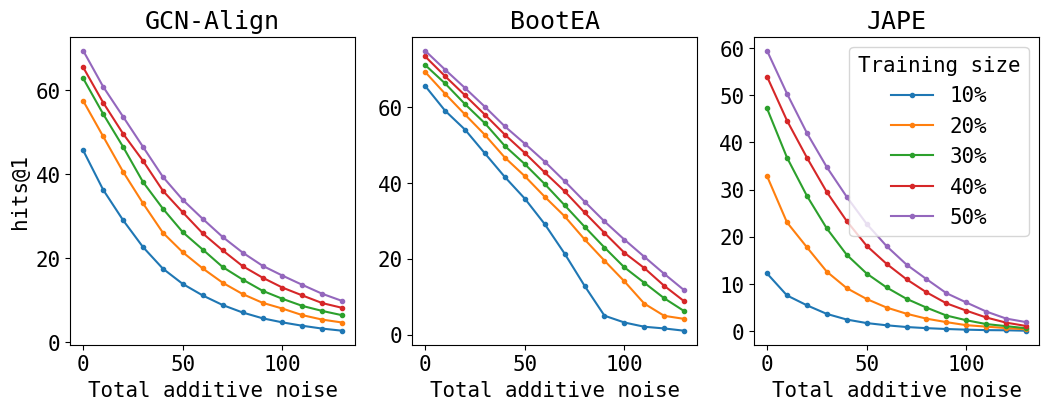

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=3)#, constrained_layout=True)
fig.set_size_inches(12.5, 4)
#fig.suptitle('Training size effect', fontsize=15)

#plt.show()

random_results = ids_results.loc[ids_results.method.str.contains('gcnalign_random')]
grouped_df = random_results[['hits@1', 'combined_error', 'training_size']].groupby(['combined_error', 'training_size'])
grouped_df.mean().reset_index().pivot(index="combined_error", columns="training_size").plot(title = 'GCN-Align',
                    style = '.-', xlabel = 'Total additive noise',
                   ylabel='hits@1', ax = axes[0])

random_results = ids_results.loc[ids_results.method.str.contains('bootea_random')]
grouped_df = random_results[['hits@1', 'combined_error', 'training_size']].groupby(['combined_error', 'training_size'])
grouped_df.mean().reset_index().pivot(index="combined_error", columns="training_size").plot(title = 'BootEA',
                    style = '.-', xlabel = 'Total additive noise',
                   ylabel=None, ax = axes[1])

random_results = ids_results.loc[ids_results.method.str.contains('jape_random')]
grouped_df = random_results[['hits@1', 'combined_error', 'training_size']].groupby(['combined_error', 'training_size'])
grouped_df.mean().reset_index().pivot(index="combined_error", columns="training_size").plot(title = 'JAPE',
                    style = '.-', xlabel = 'Total additive noise',
                   ylabel=None, ax = axes[2])

axes[2].legend(['10%', '20%', '30%', '40%', '50%'], title='Training size')
axes[0].get_legend().remove()
axes[1].get_legend().remove()
fig.savefig('training_size_effect.pdf', dpi=100, bbox_inches='tight')

In [40]:
results_df_60 = all_results_df.loc[(all_results_df.combined_error==60)*all_results_df.method.str.contains('random')]
ids_60_df = results_df_60.loc[results_df_60.dataset == 'ids']
dbp_60_df = results_df_60.loc[(results_df_60.dataset == 'dbp')*(results_df_60.method.str.contains('gcn'))]

In [41]:
idx = ids_60_df.groupby(['training_size', 'method'])['hits@1'].transform(max) == ids_60_df['hits@1']
top_ids = ids_60_df[idx][['training_size', 'method', 'error_comb']].sort_values(by = ['training_size', 'method'])
print(top_ids.pivot(index = 'method', columns = 'training_size')['error_comb'].to_latex())

\begin{tabular}{llllll}
\toprule
training\_size &            10 &            20 &           30 &           40 &           50 \\
method          &               &               &              &              &              \\
\midrule
bootea\_random   &   (50, 10, 0) &   (50, 10, 0) &  (50, 0, 10) &  (50, 10, 0) &  (50, 10, 0) \\
gcnalign\_random &  (40, 10, 10) &  (40, 10, 10) &  (50, 0, 10) &  (50, 0, 10) &  (50, 0, 10) \\
jape\_random     &   (0, 40, 20) &   (0, 40, 20) &  (0, 30, 30) &  (0, 30, 30) &  (0, 40, 20) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_10346/420741622.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top_ids.pivot(index = 'method', columns = 'training_size')['error_comb'].to_latex())


In [42]:
idx = dbp_60_df.groupby(['training_size', 'method'])['hits@1'].transform(max) == dbp_60_df['hits@1']
top_dbp = dbp_60_df[idx][['training_size', 'method', 'error_comb']].sort_values(by = ['training_size', 'method'])
print(top_dbp.pivot(index = 'method', columns = 'training_size')['error_comb'].to_latex())

\begin{tabular}{llllll}
\toprule
training\_size &           10 &            20 &           30 &           40 &           50 \\
method          &              &               &              &              &              \\
\midrule
gcnalign\_random &  (0, 30, 30) &  (10, 30, 20) &  (0, 30, 30) &  (0, 30, 30) &  (0, 30, 30) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_10346/2083296947.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top_dbp.pivot(index = 'method', columns = 'training_size')['error_comb'].to_latex())


## Negative sampling

In [43]:
neg_samp_df = all_results_df.loc[(all_results_df.training_size==30)*(all_results_df.align_error == 0)]

In [44]:
grouped_df = neg_samp_df[['combined_error', 'method', 'hits@1', 'dataset']].groupby(['method', 'combined_error', 'dataset'])
all_sample_results = grouped_df.mean().reset_index()
dbp_neg_sam_mean = all_sample_results.loc[all_sample_results.dataset=='dbp'].pivot(index="combined_error", columns="method", values="hits@1")
ids_neg_sam_mean = all_sample_results.loc[all_sample_results.dataset=='ids'].pivot(index="combined_error", columns="method", values="hits@1")

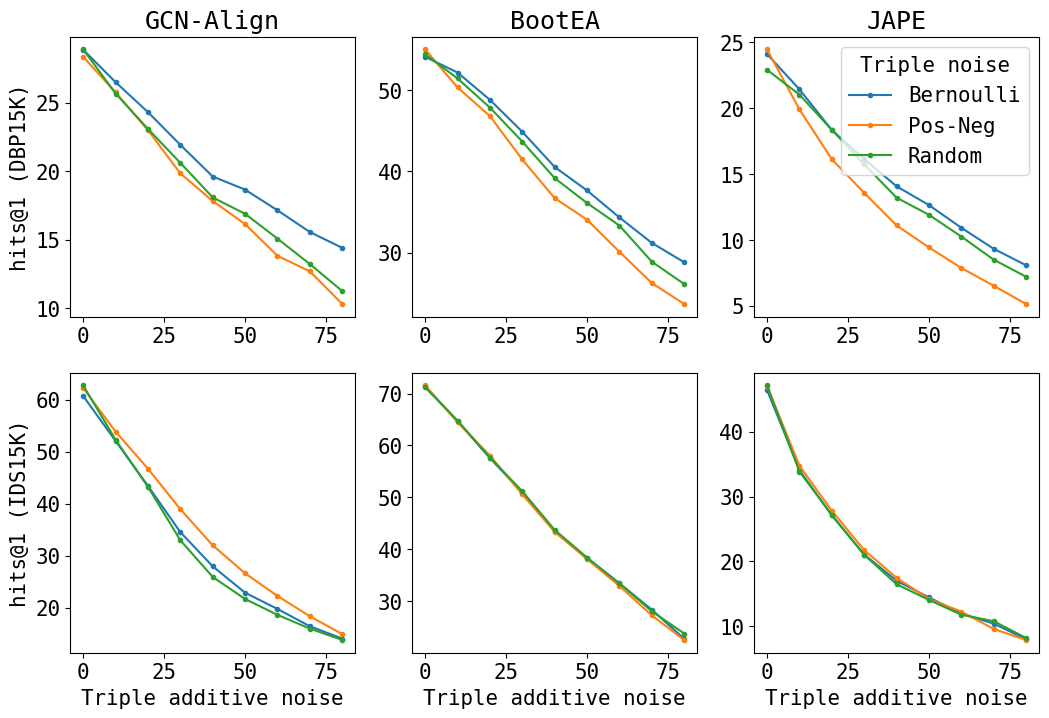

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=3)#, constrained_layout=True)
fig.set_size_inches(12.5, 8)
#fig.suptitle('Sampling method effect', fontsize=15)

dbp_neg_sam_mean.filter(regex='gcn').plot.line(title = 'GCN-Align', 
                    style='.-', xlabel = '',
                   ylabel='hits@1 (DBP15K)', ax=axes[0,0])

dbp_neg_sam_mean.filter(regex='bootea').plot.line(title = 'BootEA', 
                    style='.-', xlabel = '',
                   ylabel=None, ax=axes[0,1])

dbp_neg_sam_mean.filter(regex='jape').plot.line(title = 'JAPE', 
                    style='.-', xlabel = '',
                   ylabel=None, ax=axes[0,2])

ids_neg_sam_mean.filter(regex='gcn').plot.line(title = None, 
                    style='.-', xlabel = 'Triple additive noise',
                   ylabel='hits@1 (IDS15K)', ax=axes[1,0])

ids_neg_sam_mean.filter(regex='bootea').plot.line(title = None, 
                    style='.-', xlabel = 'Triple additive noise',
                   ylabel=None, ax=axes[1,1])

ids_neg_sam_mean.filter(regex='jape').plot.line(title = None, 
                    style='.-', xlabel = 'Triple additive noise',
                   ylabel=None, ax=axes[1,2])
axes[0,2].legend(['Bernoulli', 'Pos-Neg', 'Random'], title='Triple noise')

axes[0,0].get_legend().remove()
axes[0,1].get_legend().remove()
axes[1,0].get_legend().remove()
axes[1,1].get_legend().remove()
axes[1,2].get_legend().remove()
fig.savefig('neg_triple_perf.pdf', dpi=100, bbox_inches='tight')

In [46]:
pivoted_df = neg_samp_df.pivot_table('hits@1', ['source_error', 'target_error', 'dataset'],'method').reset_index()
dbp_neg_sam_pivot = pivoted_df.loc[pivoted_df.dataset == 'dbp']
ids_neg_sam_pivot = pivoted_df.loc[pivoted_df.dataset == 'ids']

In [47]:
print('GCN-Align')
res = scipy.stats.wilcoxon((dbp_neg_sam_pivot.gcnalign_bernoulli - dbp_neg_sam_pivot.gcnalign_random).values, alternative='greater')
print('Bernoulli > random p-val: ' + str(res.pvalue))
res = scipy.stats.wilcoxon((dbp_neg_sam_pivot.gcnalign_random - dbp_neg_sam_pivot.gcnalign_posneg).values, alternative='greater')
print('Random > Pos-Neg p-val: ' + str(res.pvalue))

print('\nBootEA')
#res = scipy.stats.wilcoxon((dbp_neg_sam_pivot.bootea_bernoulli - dbp_neg_sam_pivot.bootea_random).values, alternative='greater')
#print('Bernoulli > random p-val: ' + str(res.pvalue))
res = scipy.stats.wilcoxon((dbp_neg_sam_pivot.bootea_bernoulli - dbp_neg_sam_pivot.bootea_posneg).values, alternative='greater')
print('Random > Pos-Neg p-val: ' + str(res.pvalue))

print('\nJAPE')
res = scipy.stats.wilcoxon((dbp_neg_sam_pivot.jape_bernoulli - dbp_neg_sam_pivot.jape_random).values, alternative='greater')
print('Bernoulli > random p-val: ' + str(res.pvalue))
res = scipy.stats.wilcoxon((dbp_neg_sam_pivot.jape_random - dbp_neg_sam_pivot.jape_posneg).values, alternative='greater')
print('Random > Pos-Neg p-val: ' + str(res.pvalue))

GCN-Align
Bernoulli > random p-val: 5.960464477539063e-08
Random > Pos-Neg p-val: 6.0111284255981445e-05

BootEA
Random > Pos-Neg p-val: 5.960464477539063e-08

JAPE
Bernoulli > random p-val: 0.00012490153312683105
Random > Pos-Neg p-val: 7.450580596923828e-07


In [48]:
print('GCN-Align')
res = scipy.stats.wilcoxon((ids_neg_sam_pivot.gcnalign_posneg - ids_neg_sam_pivot.gcnalign_bernoulli).values, alternative='greater')
print('Bernoulli > random p-val: ' + str(res.pvalue))
res = scipy.stats.wilcoxon((ids_neg_sam_pivot.gcnalign_bernoulli - ids_neg_sam_pivot.gcnalign_random).values, alternative='greater')
print('Random > Pos-Neg p-val: ' + str(res.pvalue))

print('\nBootEA')
res = scipy.stats.wilcoxon((ids_neg_sam_pivot.bootea_posneg - ids_neg_sam_pivot.bootea_bernoulli).values, alternative='greater')
print('Bernoulli > random p-val: ' + str(res.pvalue))
res = scipy.stats.wilcoxon((ids_neg_sam_pivot.bootea_bernoulli - ids_neg_sam_pivot.bootea_random).values, alternative='greater')
print('Random > Pos-Neg p-val: ' + str(res.pvalue))

print('\nJAPE')
res = scipy.stats.wilcoxon((ids_neg_sam_pivot.jape_posneg - ids_neg_sam_pivot.jape_bernoulli).values, alternative='greater')
print('Bernoulli > random p-val: ' + str(res.pvalue))
res = scipy.stats.wilcoxon((ids_neg_sam_pivot.jape_bernoulli - ids_neg_sam_pivot.jape_random).values, alternative='greater')
print('Random > Pos-Neg p-val: ' + str(res.pvalue))

GCN-Align
Bernoulli > random p-val: 2.9802322387695312e-08
Random > Pos-Neg p-val: 0.0015439391136169434

BootEA
Bernoulli > random p-val: 0.9218308925628662
Random > Pos-Neg p-val: 0.8682619333267212

JAPE
Bernoulli > random p-val: 0.2209186851978302
Random > Pos-Neg p-val: 0.3075215220451355


In [49]:
def read_timing_results(results_file, dataset):
    results_df = pd.read_csv(results_file, sep='\t', names = ['method', 'training_size', 'align_error', 'source_error', 'target_error'
                                                                  , 'time'])
    results_df['dataset'] = dataset 
    return results_df

In [50]:
ids_results = read_timing_results('IDS15K_time_results.txt', 'ids')
dbp_results = read_timing_results('DBP15K_time_results.txt', 'dbp')

all_results_df = pd.concat([dbp_results,ids_results], ignore_index=True)

In [51]:
all_results_df[['method', 'time', 'dataset']].groupby(['method', 'dataset']).mean()

time
method             dataset              
bootea_bernoulli   dbp      65043.281080
                   ids      11024.565480
bootea_posneg      dbp      55594.962880
                   ids      10316.025480
bootea_random      dbp      35567.716067
                   ids       6348.536411
gcnalign_bernoulli dbp       1165.279200
                   ids        228.607887
gcnalign_posneg    dbp       1308.243640
                   ids        232.477127
gcnalign_random    dbp        257.106867
                   ids        214.609876
jape_bernoulli     dbp        486.697480
                   ids        245.312360
jape_posneg        dbp       1123.687480
                   ids        238.154360
jape_random        dbp       1659.273520
                   ids        125.406685

In [55]:
all_results_df.time.sum()/3600

3977.4172541666667